<a href="https://colab.research.google.com/github/vkthakur90/AI_Applications/blob/master/Positional_Trading_with_Auto_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
from datetime import datetime, timedelta

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
ticker = 'NIFTYBEES.NS'
prev_day = 0
scale_factor = 1.0e6

history_length = 800

arima_p = 100

num_paths = 1000
paths_to_plot = 1

risk_budget = 100000

In [ ]:
def download_data(entity):
    print(f"Downloading {ticker}")

    # Download intraday data with a 1-minute interval.
    data = yf.download(ticker, period="5y", interval="1d")

    if data.index.tzinfo is None:
        data.index = data.index.tz_localize('UTC')

    data.index = data.index.tz_convert('Asia/Kolkata')

    data_ = pd.DataFrame({
        'S' : data['Close'].values.reshape((-1,))
    }, index = data.index)

    entity['data'] = data_

In [ ]:
def calculate_return(entity):
    data = entity['data']

    data.eval('log_S = log(S)', inplace = True)
    data['r'] = scale_factor * data['log_S'].diff()

In [ ]:
def feature_engg(entity):
    data = entity['data']

    features_df = data[['S', 'r']]

    for idx in range(arima_p):
        features_df[f'r_{idx + 1}'] = features_df['r'].shift(idx + 1)

    features_df.dropna(inplace = True)

    entity['features'] = features_df

In [ ]:
def split_data(entity):
    features_df = entity['features']
    train_data = features_df.iloc[: history_length]
    test_data = features_df.iloc[history_length:]

    entity['train'] = train_data
    entity['test'] = test_data

In [ ]:
def fit_ar_model(entity):
    formula = 'r ~ ' + " + ".join([f'r_{idx + 1}' for idx in range(arima_p)])

    fit_model = smf.ols(formula, data = entity['train']).fit()

    entity['ar_model'] = fit_model

In [ ]:
def create_vol_data(entity):
    entity['vol_train'] = pd.DataFrame({'e' : entity['ar_model'].resid})
    entity['vol_train'].eval('log_e_sq = log(e ** 2)', inplace = True)

    for idx in range(arima_p):
        entity['vol_train'][f'log_e_sq_{idx + 1}'] = entity['vol_train']['log_e_sq'].shift(idx + 1)

    entity['vol_train'].dropna(inplace = True)

In [ ]:
def fit_vol_model(entity):
    formula = 'log_e_sq ~ ' + " + ".join([f'log_e_sq_{idx + 1}' for idx in range(arima_p)])

    entity['vol_model'] = smf.ols(formula, data = entity['vol_train']).fit()

    e = entity['vol_model'].resid

    N = len(e)
    ddof = N - 1 - arima_p

    var = np.sum(e ** 2)/ddof
    entity['vol_sigma'] = np.sqrt(var)

In [ ]:
def forecast_mean(entity):
    prev_data = entity['train'].iloc[-arima_p:]['r'].values.tolist()
    prev_r = entity['train']['r'].iloc[-1]

    intercept = entity['ar_model'].params.values[0]
    slopes = entity['ar_model'].params.values[1:]

    dataset = []
    N = len(entity['test'])

    for idx in range(N):
        last_value = prev_data[-arima_p:]
        input_features = np.array(last_value[::-1])
        preds = intercept + np.dot(slopes, input_features)
        prev_data += [preds]

        dataset += [[preds] + input_features.tolist()]

    entity['ar_diagnosis'] = pd.DataFrame(
        data = dataset,
        columns = ['r'] + [f'r_{idx + 1}' for idx in range(arima_p)],
        index = entity['test'].index
    )

    forecast_data = prev_data[arima_p:]

    entity['mean_forecast'] = pd.DataFrame({
        'r' : forecast_data
    }, index = entity['test'].index)

In [ ]:
def forecast_volatility(entity):
    prev_data = entity['vol_train'].iloc[-arima_p:]['log_e_sq'].values.tolist()

    intercept = entity['vol_model'].params.values[0]
    slopes = entity['vol_model'].params.values[1:]

    dataset = []
    N = len(entity['test'])

    for idx in range(N):
        last_value = prev_data[-arima_p:]
        input_features = np.array(last_value[::-1])
        preds = intercept + np.dot(slopes, input_features)
        prev_data += [preds]

        dataset += [[preds] + input_features.tolist()]

    entity['vol_diagnosis'] = pd.DataFrame(
        data = dataset,
        columns = ['log_e_sq'] + [f'log_e_sq_{idx + 1}' for idx in range(arima_p)],
        index = entity['test'].index
    )


    forecast_data = prev_data[arima_p:]

    entity['vol_forecast'] = pd.DataFrame({
        'log_e_sq' : forecast_data
    }, index = entity['test'].index)

    entity['vol_forecast'].eval('e = sqrt(exp(log_e_sq))', inplace = True)
    entity['vol_forecast'].eval('neg_e = -sqrt(exp(log_e_sq))', inplace = True)

In [ ]:
def monte_carlo_paths(entity):
    N = len(entity['test'])
    random_numbers_1 = np.random.standard_normal(size = [N, num_paths])
    random_numbers_2 = np.random.standard_normal(size = [N, num_paths])

    prev_price = entity['train']['S'].iloc[-1]

    mean = entity['mean_forecast']['r'].values[..., np.newaxis]
    log_e_sq = entity['vol_forecast']['log_e_sq'].values[..., np.newaxis]
    vol_sigma = 0.5 * entity['vol_sigma']

    vol = np.exp(log_e_sq / 2 + (vol_sigma / np.sqrt(2)) * random_numbers_1)
    predicted_returns = mean + vol * random_numbers_2

    entity['monte_carlo_return_forecast'] = pd.DataFrame(
        data = predicted_returns,
        columns = [f'mcp_{idx + 1}' for idx in range(num_paths)],
        index = entity['test'].index
    )

    predicted_price = prev_price * np.exp(np.cumsum(predicted_returns/scale_factor, axis = 0))

    entity['monte_carlo_price_forecast'] = pd.DataFrame(
        data = predicted_price,
        columns = [f'mcp_{idx + 1}' for idx in range(num_paths)],
        index = entity['test'].index
    )

    entity['monte_carlo_quantiles'] = entity['monte_carlo_price_forecast'].quantile([0.025, 0.25, 0.50, 0.75, .975], axis = 1).T
    entity['monte_carlo_quantiles'].columns = ['low_ci', 'quart_1st', 'median', 'quart_3rd', 'high_ci']

In [ ]:
def trading_strategy(entity):
    long_risk = entity['monte_carlo_quantiles']['low_ci'].min()
    short_risk = entity['monte_carlo_quantiles']['high_ci'].max()

    strategy_df = pd.DataFrame({
        'S' : entity['test']['S']
    })

    strategy_df.eval('frac = (S - @long_risk) / (@short_risk - @long_risk)', inplace = True)
    strategy_df.eval('short_risk_budget = frac * @risk_budget', inplace = True)
    strategy_df.eval('long_risk_budget = @risk_budget - short_risk_budget', inplace = True)

    strategy_df.eval('long_var =  100 * (S - @long_risk)/S', inplace = True)
    strategy_df.eval('long_position_size = 100 *  long_risk_budget / long_var', inplace = True)
    strategy_df.eval('long_units = floor(long_position_size/S + 0.5)', inplace = True)

    strategy_df['prev_long_units'] = strategy_df['long_units'].shift(1)
    strategy_df['prev_long_units'].fillna(0, inplace = True)
    strategy_df.eval('delta_long_units = prev_long_units - long_units', inplace = True)

    strategy_df.eval('long_cash_flow = delta_long_units * S', inplace = True)

    strategy_df['cum_long_cash_flow'] = strategy_df['long_cash_flow'].cumsum()

    strategy_df.eval('long_invested_value = S * long_units', inplace = True)

    strategy_df.eval('long_return = cum_long_cash_flow + long_invested_value', inplace = True)

    entity['strategy'] = strategy_df

In [ ]:
entity = {}
download_data(entity)
calculate_return(entity)
feature_engg(entity)
split_data(entity)
fit_ar_model(entity)
create_vol_data(entity)
fit_vol_model(entity)
forecast_mean(entity)
forecast_volatility(entity)
monte_carlo_paths(entity)
trading_strategy(entity)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
print(entity['ar_model'].summary())

                            OLS Regression Results                            
Dep. Variable:                      r   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     1.233
Date:                Wed, 05 Mar 2025   Prob (F-statistic):             0.0723
Time:                        16:54:27   Log-Likelihood:                -8324.9
No. Observations:                 800   AIC:                         1.685e+04
Df Residuals:                     699   BIC:                         1.732e+04
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    570.9770    410.379      1.391      0.1

In [ ]:
print(entity['vol_model'].summary())

                            OLS Regression Results                            
Dep. Variable:               log_e_sq   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.054
Date:                Wed, 05 Mar 2025   Prob (F-statistic):              0.350
Time:                        16:54:27   Log-Likelihood:                -1515.4
No. Observations:                 700   AIC:                             3233.
Df Residuals:                     599   BIC:                             3692.
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        6.1409      3.281      1.872   

In [ ]:
entity['train']

,S,r,r_1,r_2,r_3,r_4,r_5,r_6,r_7,r_8,...,r_91,r_92,r_93,r_94,r_95,r_96,r_97,r_98,r_99,r_100
Date,,,,,,,,,,,,,,,,,,,,,
2020-08-04 05:30:00+05:30,118.000000,15630.004702,-15799.453422,508.497000,-10960.425422,-6352.365984,13674.113323,-5055.183746,-756.113510,8179.152733,...,38373.486395,-71277.809626,-31956.786698,-31455.744234,-38235.844352,32197.696718,-77687.204176,-2781.190395,-48610.946754,-21695.019570
2020-08-05 05:30:00+05:30,118.029999,254.194633,15630.004702,-15799.453422,508.497000,-10960.425422,-6352.365984,13674.113323,-5055.183746,-756.113510,...,-107190.789657,38373.486395,-71277.809626,-31956.786698,-31455.744234,-38235.844352,32197.696718,-77687.204176,-2781.190395,-48610.946754
2020-08-06 05:30:00+05:30,119.019997,8352.698913,254.194633,15630.004702,-15799.453422,508.497000,-10960.425422,-6352.365984,13674.113323,-5055.183746,...,17565.172549,-107190.789657,38373.486395,-71277.809626,-31956.786698,-31455.744234,-38235.844352,32197.696718,-77687.204176,-2781.190395
2020-08-07 05:30:00+05:30,119.349998,2768.821988,8352.698913,254.194633,15630.004702,-15799.453422,508.497000,-10960.425422,-6352.365984,13674.113323,...,51140.331280,17565.172549,-107190.789657,38373.486395,-71277.809626,-31956.786698,-31455.744234,-38235.844352,32197.696718,-77687.204176
2020-08-10 05:30:00+05:30,119.970001,5181.381702,2768.821988,8352.698913,254.194633,15630.004702,-15799.453422,508.497000,-10960.425422,-6352.365984,...,35361.115086,51140.331280,17565.172549,-107190.789657,38373.486395,-71277.809626,-31956.786698,-31455.744234,-38235.844352,32197.696718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-16 05:30:00+05:30,217.899994,-779.931811,-2427.457912,-731.609705,7478.938374,7628.197009,-5276.565882,5044.538539,5256.704599,-5442.316033,...,2156.241386,4178.610612,-3295.210919,-3431.192724,1077.117464,6339.210244,10655.579145,2294.566040,-3887.752294,1393.861100
2023-10-17 05:30:00+05:30,218.550003,2978.621333,-779.931811,-2427.457912,-731.609705,7478.938374,7628.197009,-5276.565882,5044.538539,5256.704599,...,-1175.575654,2156.241386,4178.610612,-3295.210919,-3431.192724,1077.117464,6339.210244,10655.579145,2294.566040,-3887.752294
2023-10-18 05:30:00+05:30,217.199997,-6196.261264,2978.621333,-779.931811,-2427.457912,-731.609705,7478.938374,7628.197009,-5276.565882,5044.538539,...,6351.103886,-1175.575654,2156.241386,4178.610612,-3295.210919,-3431.192724,1077.117464,6339.210244,10655.579145,2294.566040


<Axes: xlabel='Date', ylabel='r'>

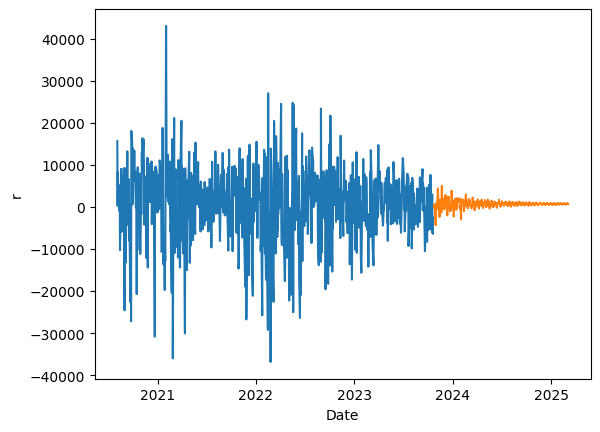

In [ ]:
sns.lineplot(x = 'Date', y = 'r', data = entity['train'].reset_index())
sns.lineplot(x = 'Date', y = 'r', data = entity['mean_forecast'].reset_index())

<Axes: xlabel='Date', ylabel='e'>

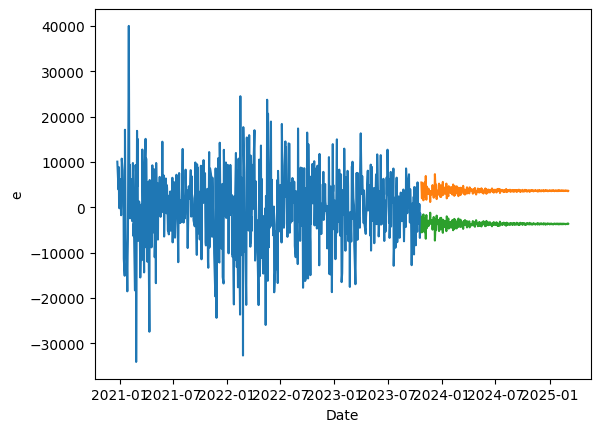

In [ ]:
sns.lineplot(x = 'Date', y = 'e', data = entity['vol_train'].reset_index())
sns.lineplot(x = 'Date', y = 'e', data = entity['vol_forecast'].reset_index())
sns.lineplot(x = 'Date', y = 'neg_e', data = entity['vol_forecast'].reset_index())

In [ ]:
len(entity['data'])

1239

In [ ]:
selected_paths = np.random.choice(entity['monte_carlo_price_forecast'].columns, paths_to_plot, replace=False)

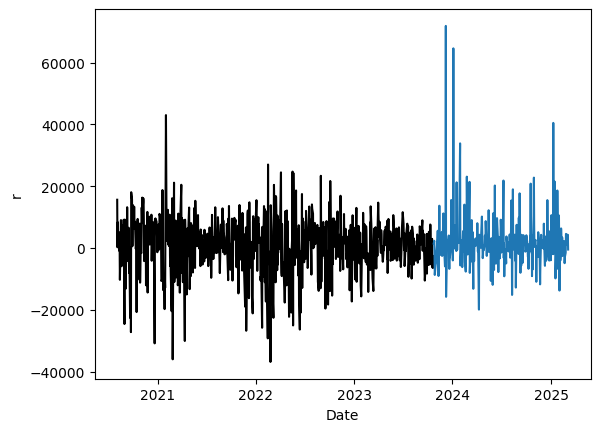

In [ ]:
sns.lineplot(x = 'Date', y = 'r', data = entity['train'].reset_index(), color = 'black')
for p in selected_paths:
    sns.lineplot(x = 'Date', y = p, data = entity['monte_carlo_return_forecast'].reset_index())


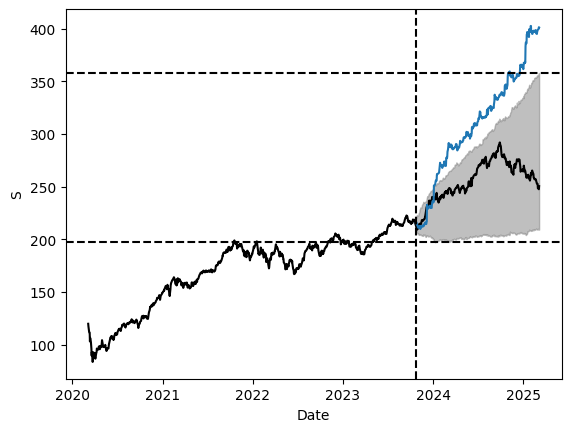

In [ ]:
sns.lineplot(x = 'Date', y = 'S', data = entity['data'].reset_index(), color = 'black')

for p in selected_paths:
    sns.lineplot(x = 'Date', y = p, data = entity['monte_carlo_price_forecast'].reset_index())

plt.fill_between(entity['monte_carlo_quantiles'].index, entity['monte_carlo_quantiles']['low_ci'], entity['monte_carlo_quantiles']['high_ci'], color = 'grey', alpha = 0.5)
plt.axhline(entity['monte_carlo_quantiles']['low_ci'].min(), linestyle = '--', color = 'black')
plt.axhline(entity['monte_carlo_quantiles']['high_ci'].max(), linestyle = '--', color = 'black')
plt.axvline(entity['monte_carlo_quantiles'].index[0], linestyle = '--', color = 'black')

In [ ]:
entity['monte_carlo_quantiles']['low_ci'].min()

197.1722634890834

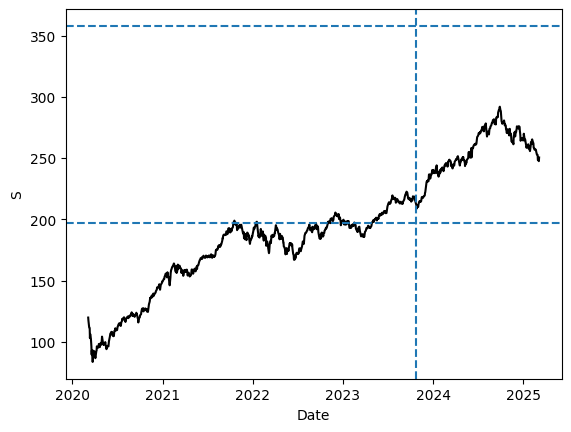

In [ ]:
sns.lineplot(x = 'Date', y = 'S', data = entity['data'].reset_index(), color = 'black')
plt.axhline(entity['monte_carlo_quantiles']['low_ci'].min(), linestyle = '--')
plt.axhline(entity['monte_carlo_quantiles']['high_ci'].max(), linestyle = '--')
plt.axvline(entity['monte_carlo_quantiles'].index[0], linestyle = '--')

<Axes: xlabel='Date', ylabel='long_return'>

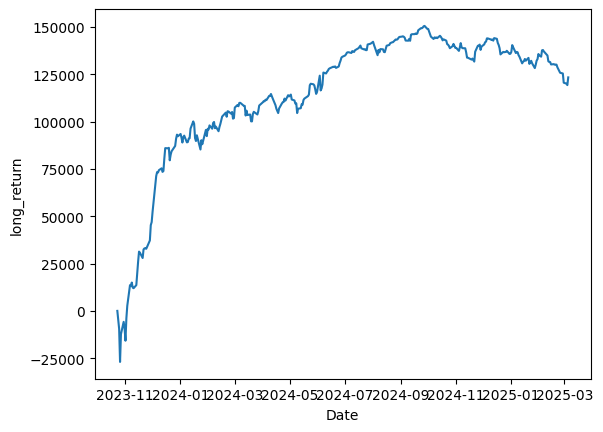

In [ ]:
sns.lineplot(x = 'Date', y = 'long_return', data = entity['strategy'].reset_index())

In [ ]:
entity['strategy']

,S,frac,short_risk_budget,long_risk_budget,long_var,long_position_size,long_units,prev_long_units,delta_long_units,long_cash_flow,cum_long_cash_flow,long_invested_value,long_return
Date,,,,,,,,,,,,,
2023-10-23 05:30:00+05:30,213.169998,0.099503,9950.330732,90049.669268,7.504684,1.199913e+06,5629.0,0.0,-5629.0,-1.199934e+06,-1.199934e+06,1.199934e+06,0.000000
2023-10-25 05:30:00+05:30,211.479996,0.088992,8899.176705,91100.823295,6.765525,1.346545e+06,6367.0,5629.0,-738.0,-1.560722e+05,-1.356006e+06,1.346493e+06,-9513.023743
2023-10-26 05:30:00+05:30,208.740005,0.071949,7194.947351,92805.052649,5.541699,1.674668e+06,8023.0,6367.0,-1656.0,-3.456734e+05,-1.701680e+06,1.674721e+06,-26958.541565
2023-10-27 05:30:00+05:30,210.570007,0.083332,8333.178721,91666.821279,6.362608,1.440711e+06,6842.0,8023.0,1181.0,2.486832e+05,-1.452996e+06,1.440720e+06,-12276.436874
2023-10-30 05:30:00+05:30,211.520004,0.089241,8924.061369,91075.938631,6.783160,1.342677e+06,6348.0,6842.0,494.0,1.044909e+05,-1.348506e+06,1.342729e+06,-5776.557755
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-27 05:30:00+05:30,252.559998,0.344503,34450.269585,65549.730415,21.930525,2.988972e+05,1183.0,1177.0,-6.0,-1.515360e+03,-1.733821e+05,2.987785e+05,125396.427032
2025-02-28 05:30:00+05:30,248.449997,0.318939,31893.916064,68106.083936,20.639056,3.299864e+05,1328.0,1183.0,-145.0,-3.602525e+04,-2.094073e+05,3.299416e+05,120534.296310
2025-03-03 05:30:00+05:30,248.050003,0.316451,31645.126367,68354.873633,20.511082,3.332583e+05,1344.0,1328.0,-16.0,-3.968800e+03,-2.133761e+05,3.333792e+05,120003.104416
